In [1]:
import os, random
import cv2
import numpy as np
import pyvista as pv
import torch
import matplotlib.pyplot as plt

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [191]:
def sample_clip_camera_pose():
    az = random.uniform(-85, 85)
    el = random.uniform(-30, 30)
    dist = random.uniform(35, 60)
    x = dist * np.cos(np.radians(el)) * np.cos(np.radians(az))
    y = dist * np.cos(np.radians(el)) * np.sin(np.radians(az))
    z = dist * np.sin(np.radians(el))
    return np.array([x, y, z])

def composite_images(background, foreground, mask):
    return foreground * mask[..., None] + background * (1 - mask[..., None])

In [192]:
# 1. Load the clipMesh.obj into PyVista and apply a metallic material
clip_mesh_path = "/home/exouser/pose_estim/clipestimator/data/mesh/clipMesh.obj"
mesh = pv.read(clip_mesh_path)

# Add a per-vertex color array if you like; here we just use a uniform silver
silver = np.full((mesh.n_points, 3), 0.8)
mesh["Color"] = silver

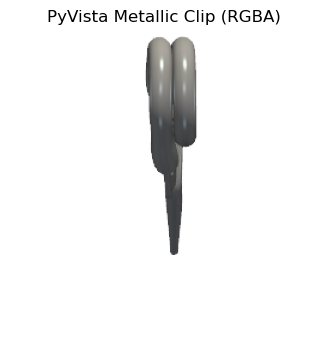

In [210]:
def render_clip_pyvista(cam_pos):
    """
    Render the clip off-screen with a transparent background, so
    that the returned image has a correct alpha channel.
    
    Returns an (H, W, 4) float32 RGBA array in [0,1].
    """
    # 1) Create a new off-screen Plotter
    p = pv.Plotter(off_screen=True, window_size=(256, 256))
    
    # 2) Add the mesh with metallic properties
    p.add_mesh(
        mesh,
        scalars="Color",
        rgb=True,
        smooth_shading=True,
        specular=1.0,
        specular_power=50.0,
        ambient=0.005,
        diffuse=0.9
    )
    
    # 3) Position the camera
    p.camera_position = [
        (cam_pos[0], cam_pos[1], cam_pos[2]),  # camera location
        (0, 0, 0),                             # focal point at origin
        (0, 0, 1),                             # view-up vector
    ]
    
    # 4) Add a “headlight” at the camera
    headlight = pv.Light(position=cam_pos, color=[1, 1, 1], light_type='headlight')
    p.add_light(headlight)
    
    # 5) Screenshot with transparency
    img = p.screenshot(return_img=True, transparent_background=True)
    p.close()
    
    # 6) Normalize to [0,1]
    img = img.astype(np.float32) / 255.0  # shape (H, W, 4)
    return img

# Quick test:
cam = sample_clip_camera_pose()
rgba = render_clip_pyvista(cam)
plt.figure(figsize=(4,4))
plt.imshow(rgba)
plt.axis("off")
plt.title("PyVista Metallic Clip (RGBA)")
plt.show()

In [211]:
# 3.
def load_backgrounds(bg_folder):
    bg_files = [os.path.join(bg_folder, f) for f in os.listdir(bg_folder)
                if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    backgrounds = [cv2.imread(f) for f in bg_files]
    # Convert BGR to RGB
    backgrounds = [cv2.cvtColor(bg, cv2.COLOR_BGR2RGB) for bg in backgrounds]
    return backgrounds

def load_foreign_objects(obj_folder):
    obj_files = [os.path.join(obj_folder, f) for f in os.listdir(obj_folder)
                 if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    foreign_objs = [cv2.imread(f, cv2.IMREAD_UNCHANGED) for f in obj_files]
    # Assume these images have alpha channels or are prepared to be overlaid.
    return foreign_objs

def load_foreign_objects(obj_folder, target_size=None):
    foreign_objs = []
    for fname in os.listdir(obj_folder):
        if not fname.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue
        path = os.path.join(obj_folder, fname)
        img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
        if img is None:
            continue
        
        # Ensure we have 4 channels (BGRA):
        if img.ndim == 2:
            # grayscale → BGRA
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGRA)
        elif img.shape[2] == 3:
            # BGR → BGRA with full alpha
            alpha = np.ones(img.shape[:2], dtype=np.uint8) * 255
            img = np.dstack([img, alpha])
        
        # Split channels and convert to RGB + alpha
        b, g, r, a = cv2.split(img)
        rgb = cv2.merge([r, g, b])
        alpha = a
        
        # Resize if requested
        if target_size is not None:
            rgb   = cv2.resize(rgb,   target_size, interpolation=cv2.INTER_AREA)
            alpha = cv2.resize(alpha, target_size, interpolation=cv2.INTER_NEAREST)
        
        # Normalize to [0,1]
        rgb_f   = rgb.astype(np.float32)   / 255.0
        alpha_f = alpha.astype(np.float32) / 255.0
        
        foreign_objs.append((rgb_f, alpha_f))
    
    return foreign_objs

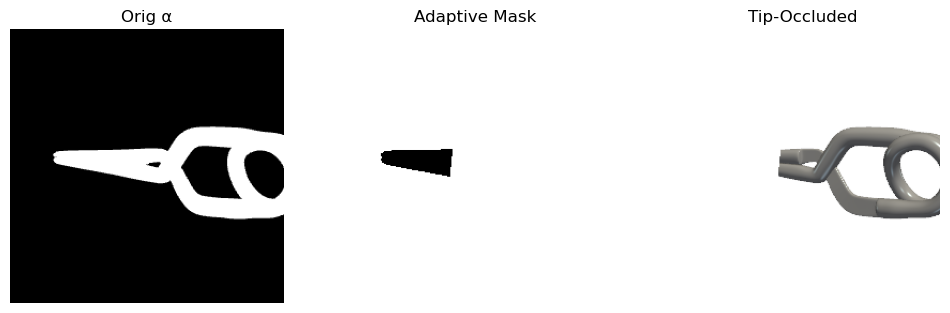

In [222]:
import numpy as np
import matplotlib.pyplot as plt

def generate_occlusion_mask_pca_adaptive(
    clip_alpha, 
    occlusion_level=0.3, 
    width_symmetry_thresh=0.999
):
    """
    Occlude the clip's tip end along its principal axis—unless
    the tip is effectively hidden, in which case do nothing.
    
    clip_alpha: H×W float mask (>0 where clip is).
    occlusion_level: fraction [0–1] of the clip’s length to occlude.
    width_symmetry_thresh: if min_width / max_width > this, skip occlusion.
    """
    H, W = clip_alpha.shape
    mask = np.ones_like(clip_alpha, dtype=np.float32)
    rows, cols = np.nonzero(clip_alpha > 0)
    if rows.size == 0:
        return mask

    # Build centered (x=col, y=row) coordinates
    pts = np.stack([cols, rows], axis=1).astype(np.float32)
    centroid = pts.mean(axis=0)
    centered = pts - centroid[None, :]

    # PCA for principal axis
    cov = centered.T @ centered
    eigvals, eigvecs = np.linalg.eigh(cov)
    axis = eigvecs[:, np.argmax(eigvals)]

    # Project onto that axis
    projections = centered @ axis
    min_p, max_p = projections.min(), projections.max()
    span = max_p - min_p
    if span <= 0:
        return mask

    # Compute widths near each end
    delta = span * 0.1  # sample 10% in from each end
    width_max = np.sum(projections > max_p - delta)
    width_min = np.sum(projections < min_p + delta)
    # If the narrower end is not much narrower, skip occlusion
    if min(width_max, width_min) / max(width_max, width_min) > width_symmetry_thresh:
        return mask

    # Decide which end is the tip
    occl_dist = occlusion_level * span
    if width_max < width_min:
        # tip at max_p end
        thresh = max_p - occl_dist
        tip_idx = projections > thresh
    else:
        # tip at min_p end
        thresh = min_p + occl_dist
        tip_idx = projections < thresh

    # Zero out tip pixels
    mask[rows[tip_idx], cols[tip_idx]] = 0.0
    return mask

# --- TEST CELL ---
cam = sample_clip_camera_pose()
rgba = render_clip_pyvista(cam)      # H×W×4
clip_rgb   = rgba[..., :3]
clip_alpha = rgba[..., 3]

# Build adaptive mask (skip if tip hidden)
mask = generate_occlusion_mask_pca_adaptive(
    clip_alpha, 
    occlusion_level=0.3, 
    width_symmetry_thresh=0.8
)

# Apply and composite on white
alpha_occ = clip_alpha * mask
white_bg = np.ones_like(clip_rgb)
occluded = clip_rgb * alpha_occ[..., None] + white_bg * (1 - alpha_occ[..., None])

# Display
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(clip_alpha, cmap="gray");    plt.title("Orig α");     plt.axis("off")
plt.subplot(1,3,2)
plt.imshow(mask,  cmap="gray");    plt.title("Adaptive Mask"); plt.axis("off")
plt.subplot(1,3,3)
plt.imshow(occluded);               plt.title("Tip‐Occluded"); plt.axis("off")
plt.show()


In [213]:
backgrounds = load_backgrounds("/home/exouser/pose_estim/clipestimator/data/backgrounds")
backgrounds = [cv2.resize(bg, (256,256)).astype(np.float32)/255.0 for bg in backgrounds]
foreign_objects = load_foreign_objects("/home/exouser/pose_estim/clipestimator/data/objects", target_size=(256,256))

In [214]:
def generate_synthetic_sample_pyvista(
    blur_kernel=(5,5),    # must be odd integers
    blur_sigma=1.0        # standard deviation in X (and Y)
):
    # 1. Pick background
    bg = random.choice(backgrounds)
    
    # 2. Render clip
    cam_pos = sample_clip_camera_pose()
    rgba = render_clip_pyvista(cam_pos)
    clip_rgb   = rgba[..., :3]
    clip_alpha = rgba[..., 3]
    
    # 3. Occlusion
    occ = generate_occlusion_mask_pca_adaptive(clip_alpha)
    alpha_occ = clip_alpha * occ
    
    # 4. Composite
    composite = composite_images(bg, clip_rgb, alpha_occ)
    
    # 5. Apply Gaussian blur
    #    Note: composite is float32 [0,1], cv2 expects [0,255] or 0–1 is OK for small floats
    composite_blurred = cv2.GaussianBlur(
        composite, 
        ksize=blur_kernel, 
        sigmaX=blur_sigma,
        borderType=cv2.BORDER_REFLECT
    )
    
    # 6. (Optional) add noise
    noise = np.random.normal(0, 0.02, composite_blurred.shape)
    composite_noisy = np.clip(composite_blurred + noise, 0, 1)
    
    # 7. Return final image and ground-truth camera
    return composite_noisy, cam_pos

Text(0.5, 1.0, 'Synthetic Sample (cam=[ 28.8 -21.3  -0.8])')

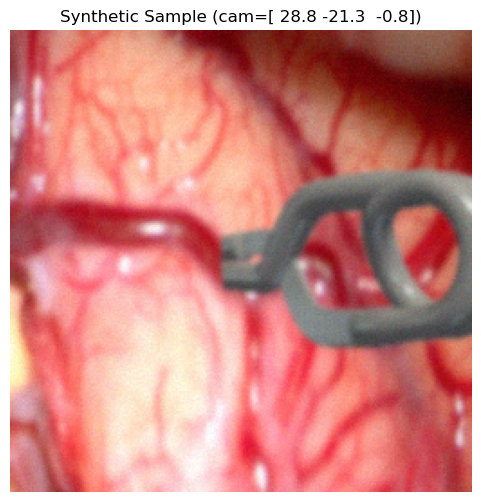

In [226]:
sample_img, gt_cam = generate_synthetic_sample_pyvista(blur_kernel=(9,9), blur_sigma=1.5)
plt.figure(figsize=(6,6))
plt.imshow(sample_img)
plt.axis("off")
plt.title(f"Synthetic Sample (cam={gt_cam.round(1)})")